# Credit Card Fraud Detection

https://www.kaggle.com/mlg-ulb/creditcardfraud

Nos descargamos el dataset de Kaggle para estudiar este problema.

Para ponernos en contexto vemos la explicación que dan sobre el dataset:

- Son transacciones que han ocurrido en Septiembre de 2013 en Europa
- Las operaciones han ocurrido en 2 días
- 492 de 284807 operaciones son fraudes
- Tomaremos como clase positiva la opción de fraude

- Las variables V1, V2,... V28 son las obtenidas después de hacer un PCA (reducción de dimensionalidad), es decir que estas variables no son interpretables (por temas de confidencialidad)
- Hay dos variables a las que no se les ha hecho el PCA: 'Time', que contiene los segundos entre cada transacción y la primera transacción del dataset, y 'Amount', que indica el importe de la transacción.
- La variable objetivo es en este caso 'Class', que toma los valores de 1 en caso de fraude y 0 en el caso contrario.

Nos piden medir la **accuracy** del modelo usando AUC (Area Under the Curve) de la curva Precision-Recall. 

------------------------------------------------------------------------------------------------------------------

*Nota teórica:* ***Diferencia entre curva ROC y curva Precision-Recall***


Las curvas ROC enfrentan los True Positive y los False Positive.

Las curvas Precision-Recall enfrentan los True Positive y todos los valores predichos como True (True Positive + False Positive).

Las curvas ROC se suelen usar cuando la pertenencia a cada una de las clases está equilibrada. En nuestro caso, 492/284807 = 0.172% de las transacciones son fraudulentas así que es más significativo hacer el área bajo la curva Precision-Recall que bajo la curva ROC.

Que los datos no estén equilibrados se traduce en que nos interesa más que nuestro modelo sepa predecir bien el número de casos positivos (fraude) que los casos normales de no-fraude. La curva Precision-Recall no usa True Negatives, es decir que no le interesa saber como de bien he predicho el caso de no-fraude. Solo se centra en evaluar la predicción sobre la clase minoritaria.

Dejo este link (en inglés) sobre cuando usar cada tipo de curva: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

------------------------------------------------------------------------------------------------------------------

### Esquema de trabajo

I. Entender los datos

II. Preprocesado

       a) Escalar las variables
       b) Separar en train y test
       c) Aplicar Random Under-Sampling
       
III. Aplicar modelos de clasificación

------------------------------------------------------------------------------------------------------------------

### I. Entender los datos


In [2]:
# Importamos los paquetes con los que vamos a trabajar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# Empezamos a trabajar con el dataset
path = './creditcard.csv'
df = pd.read_csv(path)

In [31]:
# Vemos que forma tienen los datos
print('Este dataframe tiene %s filas y %s columnas' %(df.shape[0],df.shape[1]))

Este dataframe tiene 284807 filas y 31 columnas


In [45]:
df.head() # Vemos las 5 primeras filas

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
208245,1.957778,-0.229079,-0.896589,0.124183,-0.274162,-0.228216,-0.659842,0.212668,1.147953,-0.525280,...,-0.579256,0.419039,0.545722,-0.560647,-0.329822,0.013613,-0.015389,0,-0.349551,0.889090
235370,1.882305,0.479376,-1.392736,3.523096,0.976164,-0.023798,0.600700,-0.213920,-1.203219,1.503339,...,-0.751995,0.097340,-1.078736,-0.039785,-0.195953,-0.072082,-0.046228,0,-0.034142,1.127571
35664,-1.160601,2.032691,0.671993,2.804036,-0.578304,0.118644,-0.367879,1.016014,-1.272624,0.902662,...,0.078971,0.119803,0.044451,-0.375207,0.148273,0.073143,0.066751,0,-0.332919,-1.191876
131118,-0.716576,1.314904,0.806218,-0.086121,-0.072173,-0.504290,0.294542,0.504736,-0.842842,-0.581725,...,-0.627932,0.008459,-0.043156,-0.109876,0.076030,0.114225,0.023130,0,-0.297296,-0.322415
283386,-0.536740,1.397157,0.025456,-0.444122,1.090644,-0.560403,1.080251,-0.195815,-0.350055,-0.671812,...,-0.681375,-0.042028,0.536625,-0.387227,0.205434,0.076517,0.246719,0,-0.349671,1.616030


In [46]:
# Comprobamos que la columna 'Time' parece que tiene números consecutivos
# Vamos a ver 5 filas aleatorias en lugar de las 5 primeras
df.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
112264,1.081778,-0.057014,-0.097175,1.221222,0.279437,0.421648,0.168332,0.014343,0.317313,-0.166637,...,-0.264519,-0.259754,-0.916089,0.775317,-0.259036,0.025051,0.020045,0,-0.001398,-0.468073
173720,-2.238563,-1.695041,1.454965,2.806086,3.950524,-0.313046,-1.064598,0.181998,-3.404684,2.255874,...,-0.056256,-0.078761,-0.228679,0.866583,0.420016,-0.219509,-0.113321,0,-0.323484,0.564355
200450,-0.705942,0.738865,1.102679,-0.545122,0.760047,-0.163482,0.911397,0.119210,-0.449457,-0.785907,...,-0.654531,-0.279110,0.709607,0.622145,-0.386001,0.004558,0.052225,0,-0.281184,0.813386
90997,-0.714012,0.396157,0.842847,-1.103219,-1.414446,0.333889,1.042313,-0.429196,-1.609723,0.826793,...,0.858603,-0.311316,0.102998,-0.379598,-0.238871,-0.141063,0.023789,0,0.641894,-0.664290
50987,1.017694,-0.929331,0.605299,-1.357191,-1.198954,-0.350658,-0.579014,0.047963,1.609407,-1.061710,...,0.628552,-0.270950,0.111620,0.473131,0.102044,0.021796,0.032240,0,0.146931,-1.054515


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Se ve que es un dataset que se ha tocado porque:
- Todas las columnas de las variables son floats
- No hay ningún missing value ni NaN

In [16]:
# Vemos qué propiedades estadísticas tiene
# Como solo podemos interpretar las variables 'Time' y 'Amount', vamos a listar solo esas dos
df[['Time','Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


Vamos a intentar interpretar las variables:

Variable 'Amount':

- La media de las transacciones es de 88€
- El 75% de las transacciones corresponde a una de 77€, es decir que en el 25% de transacciones restantes tienen que haber valores muy elevados que suban tanto la media
- La máxima transacción es de 25691€

    

Variable 'Time':

- La media y la mediana (50% de las operaciones) son bastante próximas, por lo que parece que están repartidas más o menos uniformemente en el tiempo
- El máximo es 172792 segundos, que son las 48 horas (2 días) que indica el enunciado del problema

In [4]:
import seaborn as sns

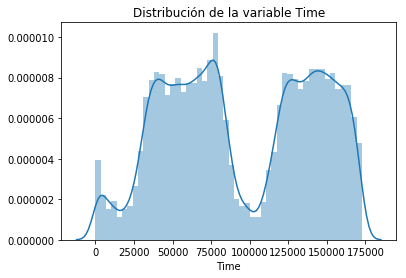

In [27]:
# Vamos a visualizar la distribución las variables 'Time' y 'Amount'
plt.title('Distribución de la variable Time')
sns.distplot(df['Time'])

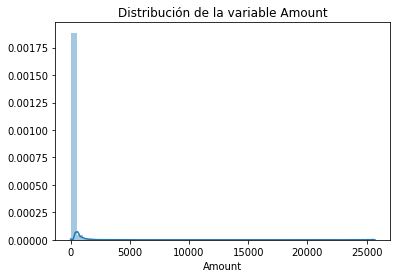

In [28]:
plt.title('Distribución de la variable Amount')
sns.distplot(df['Amount'])

Ahora vamos a ver como se reparten las transacciones fraudulentes y las no-fraudulentas

In [48]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
normal = df['Class'].value_counts()[0]
fraud = df['Class'].value_counts()[1]
print('Hay ',round(100*normal/(normal+fraud),2), '% transacciones no fraudulentas y',round(100*fraud/(normal+fraud),2),'% fraudulentas')

Hay  99.83 % transacciones no fraudulentas y 0.17 % fraudulentas


Text(0, 0.5, 'Count')

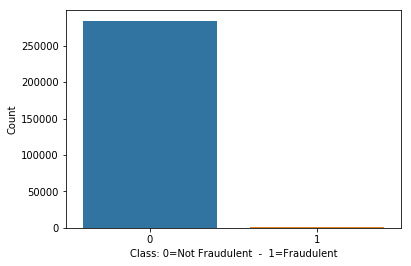

In [6]:
sns.barplot(x = df['Class'].value_counts().index, y=df['Class'].value_counts())
plt.xlabel('Class: 0=Not Fraudulent  -  1=Fraudulent')
plt.ylabel('Count')

### II. Preprocesado

#### a) Escalar las variables

A la hora de hacer el PCA a las variables V1 a V28, lo más normal es que se haya hecho un escalado de las variables originales.

In [64]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Parece que todas tienen una media centrada en 0, cuando nuestras variables 'Time' y 'Amount' tienen valores muy superiores.

Si no escalamos estas dos variables haría que algunos de nuestros algoritmos de Machine Learning les diesen unos pesos excesivos (pasaría en regresión logística) o distorsionasen las distancias (en K-vecinos), falseando por tanto el modelo.

Para evitar estos fenómenos, habría que escalar estas dos variables ('Time' y 'Amount').

In [44]:
# Importamos la librería para escalar variables
from sklearn.preprocessing import StandardScaler

# Asignamos una instancia al escalador
std_scaler = StandardScaler()

# Creamos dos nuevas columnas que llevarán los valores escalados
df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Quitamos las columnas anteriores del dataset
df.drop(['Time','Amount'], axis=1, inplace=True)

KeyError: 'Amount'

In [8]:
df.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
74172,-1.032049,-0.297365,1.714372,-1.544292,0.116785,-1.424491,0.206147,-0.153410,-1.586765,-0.055834,...,-0.619104,-0.096942,0.395061,0.323692,0.955972,-0.078472,0.059171,0,-0.236765,-0.828837
207975,0.051538,0.413707,-0.071487,-0.708951,0.839359,-0.519872,0.851737,-0.151214,0.292899,0.198160,...,-0.371093,0.169755,0.726471,-0.784846,0.068747,-0.060661,-0.098339,0,-0.320365,0.886626
116914,-0.770502,1.311165,1.068376,1.331802,-0.150431,0.066421,0.381287,0.492651,-0.564445,-0.365159,...,0.308487,-0.057945,0.111784,-0.037752,-0.223822,0.301517,0.144885,0,-0.231967,-0.428273
269182,-0.537208,0.934847,1.215810,-0.550632,1.340542,0.068996,1.513149,-0.823270,-0.236714,0.453698,...,0.964826,-0.811666,-0.738532,0.851979,0.107937,-0.867061,-0.614440,0,-0.349231,1.447967
55758,-2.211229,2.325129,-0.111247,-0.161217,0.507490,-0.351142,0.428957,0.464533,-0.863321,-0.438391,...,-0.083281,-0.255582,-0.410633,0.461623,0.338443,-1.089014,-0.216520,0,-0.350191,-1.004565


In [9]:
# Vamos a colocar las nuevas columnas al principio del dataset 

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [10]:
df.sample(5)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
71829,-0.124939,-0.849790,0.986260,-0.736307,1.034790,0.087735,-0.918713,0.864045,-0.920289,0.527484,...,-0.102369,-0.109065,-0.182476,0.098157,-0.240239,-0.096588,0.983044,-0.020590,0.003444,0
66897,-0.343354,-0.895927,1.186594,0.585160,0.103621,2.383549,0.118333,-0.553260,0.350085,-0.040807,...,-0.261657,0.017025,-0.086635,-0.096437,0.295491,0.644628,0.056485,-0.054301,-0.003704,0
193225,-0.333279,0.741831,-1.658133,-0.600654,1.203453,-0.232516,2.173587,-1.108398,-0.043418,0.192026,...,0.369746,-0.084555,-0.748026,-0.018774,0.719201,0.646192,-0.431991,-0.036451,0.082981,0
69197,0.246484,-0.873964,0.915429,-1.873170,1.756837,-0.109489,-2.263026,1.212895,-1.941712,0.664108,...,0.205902,0.411370,1.239038,-0.258130,0.081313,0.328553,0.100288,0.081953,0.038163,0
25491,-0.337757,-1.288426,-0.280590,1.104517,0.939846,-0.134372,0.423075,-0.502502,0.692587,-0.014600,...,0.135171,-0.319988,-0.851497,-0.116643,-0.509514,-0.051789,0.124231,0.243826,0.089544,0


#### b) Separar en train y test

Antes de usar técnicas de Under u Oversampling para homogeneizar nuestro dataset, tendremos que separar los datos en los subconjuntos de train y test.

Aunque homogeneicemos los datos al hacer en Undersampling, lo que nos interesa luego es testear el accuracy de nuestro modelo sobre el dataset original, no sobre uno "trucado".

Entrenaremos nuestro modelo sobre los datos con under u oversampling (para así detectar los patrones) pero haremos el test sobre una porción del dataset original.

In [11]:
from sklearn.model_selection import train_test_split

In [33]:
# Definimos X e y
X = df.drop('Class', axis = 1)
y = df['Class']

In [34]:
# Aplicamos el split entre train y test
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X,y,test_size = 0.20, random_state = 42)

#### c) Aplicar Random Under-Sampling

Lo que se intenta a la hora de resamplear un dataset es que haya aproximadamente un ratio 50-50 entre las clases. 

Hay varias maneras de resamplear datasets no equilibrados. Entre ellas: 
        - OVER-sampling: se añaden copias de los elementos que son minoritarios. Se suele hacer cuando se tienen pocas entradas en el dataset.
        - UNDER-sampling: se borran entradas del grupo que está sobre-representado. Se suele hacer cuando hay muchas entradas de datos disponibles.

En este caso haremos un *Random Under-sampling* de los datos que tienen Class = 0, es decir los no-fraudulentos.

In [35]:
# Vemos cuantos elementos tenemos en la clase minoritaria
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [36]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [42]:
# Tenemos que dejar la clase 0 con el mismo número de valores que la clase 1

# Primero vamos a aleatorizar los datos.
df = df.sample(frac=1) 
# El parámetro frac indica la fracción de filas que devuelve la función.
# Por tanto frac=1 devuelve todas las filas (https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows) 


In [48]:
# Hacemos los subconjuntos de 492 elementos.
fraud_df = df[df['Class']==1]
no_fraud_df = df[df['Class']==0][:492]

In [51]:
# Los juntamos en un único dataset
usampled_df = pd.concat([fraud_df,no_fraud_df])

# Comprobamos dimensiones
usampled_df.shape

(984, 31)

In [55]:
# Aleatorizamos las filas de nuevo
new_df = usampled_df.sample(frac = 1, random_state=42)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
231733,1.989728,-0.638513,-0.889303,-0.100907,-0.107093,0.571623,-0.761372,0.298679,1.115175,0.189393,...,-0.784356,0.306780,-0.396049,-0.565668,0.288752,-0.059555,-0.055182,0,-0.213296,1.096847
42528,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,-7.083169,-11.141278,...,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,1,1.006560,-1.130302
27623,-1.033153,0.967813,1.374103,-0.563223,-0.522566,-0.654451,0.198362,0.609359,-0.145475,-0.758365,...,-0.304724,-0.083423,0.545951,-0.060677,0.353342,0.147149,0.087841,0,-0.337237,-1.267326
149145,-2.405580,3.738235,-2.317843,1.367442,0.394001,1.919938,-3.106942,-10.764403,3.353525,0.369936,...,-2.454964,1.684957,0.118263,-1.531380,-0.695308,-0.152502,-0.138866,1,-0.325283,-0.087135
153835,-22.341889,15.536133,-22.865228,7.043374,-14.183129,-0.463145,-28.215112,-14.607791,-9.481456,-20.949192,...,4.158895,1.412928,0.382801,0.447154,-0.632816,-4.380154,-0.467863,1,-0.349231,0.115485


### III. Aplicar modelos de clasificación